In [133]:
import os
import glob
import cv2
import tifffile
import numpy as np
import imagecodecs

# ----------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------
PATCH_SIZE = 256
STRIDE = PATCH_SIZE

# --- Input (original) dataset ---
ORIG_DATA_DIR = "/Users/celinewu/Documents/2024_dataset"
IMG_DIR = os.path.join(ORIG_DATA_DIR, "images")
MASK_DIR = os.path.join(ORIG_DATA_DIR, "masks")

# --- Output (processed) dataset ---
OUT_DATA_DIR = "/Users/celinewu/Documents/dataset_patches1"

# Subfolders for images
OUT_IMG_TRAIN = os.path.join(OUT_DATA_DIR, "images", "train")
OUT_IMG_TEST = os.path.join(OUT_DATA_DIR, "images", "val")

# Subfolders for masks
OUT_MASK_TRAIN = os.path.join(OUT_DATA_DIR, "masks", "train")
OUT_MASK_TEST = os.path.join(OUT_DATA_DIR, "masks", "val")

# Ensure output directories exist
os.makedirs(OUT_IMG_TRAIN, exist_ok=True)
os.makedirs(OUT_IMG_TEST, exist_ok=True)
os.makedirs(OUT_MASK_TRAIN, exist_ok=True)
os.makedirs(OUT_MASK_TEST, exist_ok=True)

# ----------------------------------------------------------------
# SPECIFIC IMAGES TO FORCE INTO TRAIN
# ----------------------------------------------------------------
force_train = [
    "train_Shival_211066", "train_Shival_230036", "train_Shival_230306",
    "train_Shival_231007", "train_Shival_231265", "train_Shival_231781",
    "train_Shival_232166", "train_Shival_232374", "train_Shival_233182",
    "train_Shival_234275", "train_Shival_234803", "train_Shival_234924",
    "train_Shival_235065"
]

# ----------------------------------------------------------------
# HELPER FUNCTIONS
# ----------------------------------------------------------------
def pad_to_multiple(img, multiple=256, border_mode=cv2.BORDER_REFLECT):
    h, w = img.shape[:2]
    pad_h = (multiple - (h % multiple)) if (h % multiple) != 0 else 0
    pad_w = (multiple - (w % multiple)) if (w % multiple) != 0 else 0
    return cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, border_mode)


def split_into_patches(img, patch_size=256, stride=256):
    h, w = img.shape[:2]
    patches = []
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
    return patches


def save_image_patch(patch, out_path):
    cv2.imwrite(out_path, patch)


def save_mask_patch(patch, out_path):
    tifffile.imwrite(out_path, patch)


def process_one_image(img_path, is_train=True):
    base_name = os.path.basename(img_path)
    file_no_ext = os.path.splitext(base_name)[0]

    # Determine output folders
    if is_train:
        out_img_folder = OUT_IMG_TRAIN
        out_mask_folder = OUT_MASK_TRAIN
    else:
        out_img_folder = OUT_IMG_TEST
        out_mask_folder = OUT_MASK_TEST

    # Extract identifier
    identifier = "_".join(file_no_ext.split("_")[-2:])

    # Build corresponding mask paths
    shoot_path = os.path.join(MASK_DIR, f"{file_no_ext}_root_mask.tif")

    # Read image and mask
    img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        print(f"[ERROR] Cannot read image: {img_path}")
        return

    mask_shoot = tifffile.imread(shoot_path) if os.path.exists(shoot_path) else None

    # Pad image and mask
    padded_img = pad_to_multiple(img_bgr, PATCH_SIZE)
    padded_shoot = pad_to_multiple(mask_shoot, PATCH_SIZE) if mask_shoot is not None else None

    # Split into patches
    img_patches = split_into_patches(padded_img, PATCH_SIZE, STRIDE)
    shoot_patches = split_into_patches(padded_shoot, PATCH_SIZE, STRIDE) if padded_shoot is not None else [None] * len(img_patches)

    # Save patches
    for idx, img_patch in enumerate(img_patches):
        patch_name_img = f"{identifier}_patch{idx}.png"
        out_img_path = os.path.join(out_img_folder, patch_name_img)
        save_image_patch(img_patch, out_img_path)

        if shoot_patches[idx] is not None:
            save_mask_patch(shoot_patches[idx], os.path.join(out_mask_folder, f"{identifier}_shoot_patch{idx}.tif"))

    print(f"[OK] Completed patches for {base_name} -> {'train' if is_train else 'test'} folder.")


# ----------------------------------------------------------------
# DATASET PROCESSING FUNCTION
# ----------------------------------------------------------------
def process_dataset_by_image():
    """
    Splits dataset into train and test based on filenames, processes each image.
    """
    # Gather all PNG images in the dataset
    image_paths = glob.glob(os.path.join(IMG_DIR, "*.png"))
    image_paths.sort()

    # Explicitly assign specific files to train
    train_image_paths = [
        path for path in image_paths if "train" in os.path.basename(path).lower()
    ]

    # Add force_train images to train_image_paths (avoid duplicates)
    train_image_paths += [
        path for path in image_paths 
        if any(force in os.path.basename(path) for force in force_train) 
        and path not in train_image_paths
    ]

    # Ensure test images include only "val" and exclude those forced into train
    test_image_paths = [
        path for path in image_paths
        if path not in train_image_paths and "val" in os.path.basename(path).lower()
    ]

    # Print preview of train and test splits
    print(f"Total images: {len(image_paths)}")
    print(f"Train images ({len(train_image_paths)}):")
    for path in train_image_paths:
        print(f" - {os.path.basename(path)}")

    print(f"Test images ({len(test_image_paths)}):")
    for path in test_image_paths:
        print(f" - {os.path.basename(path)}")

    # Prompt for confirmation before proceeding
    proceed = input("Do you want to proceed with processing these files? (yes/no): ").strip().lower()
    if proceed != "yes":
        print("Processing aborted.")
        return

    # Process training images
    for img_path in train_image_paths:
        process_one_image(img_path, is_train=True)

    # Process testing images
    for img_path in test_image_paths:
        process_one_image(img_path, is_train=False)

    print("Processing complete!")
    print(f"Train images saved in: {OUT_IMG_TRAIN}, {OUT_MASK_TRAIN}")
    print(f"Test images saved in: {OUT_IMG_TEST}, {OUT_MASK_TEST}")



if __name__ == "__main__":
    process_dataset_by_image()


Total images: 450
Train images (320):
 - train_Alican_212231_im1.png
 - train_Alican_212231_im2.png
 - train_Alican_212231_im3.png
 - train_Alican_212231_im4.png
 - train_Alican_212231_im5.png
 - train_Alican_220471_im1.png
 - train_Alican_220471_im2.png
 - train_Alican_220471_im3.png
 - train_Alican_220471_im4.png
 - train_Alican_220471_im5.png
 - train_Alican_230858_im1.png
 - train_Alican_230858_im2.png
 - train_Alican_230858_im3.png
 - train_Alican_230858_im4.png
 - train_Alican_230858_im5.png
 - train_Alican_231131_im1.png
 - train_Alican_231131_im2.png
 - train_Alican_231131_im3.png
 - train_Alican_231131_im4.png
 - train_Alican_231131_im5.png
 - train_Alican_231648_im1.png
 - train_Alican_231648_im2.png
 - train_Alican_231648_im3.png
 - train_Alican_231648_im4.png
 - train_Alican_231648_im5.png
 - train_Alican_232202_im1.png
 - train_Alican_232202_im2.png
 - train_Alican_232202_im3.png
 - train_Alican_232202_im4.png
 - train_Alican_232202_im5.png
 - train_Alican_232922_im1.png
 

Random image patch: 234924_im2_patch29.png
Looking for root mask at: /Users/celinewu/Documents/dataset_patches1/masks/train/234924_im2_shoot_patch29.tif
root Mask Unique Values: [0]


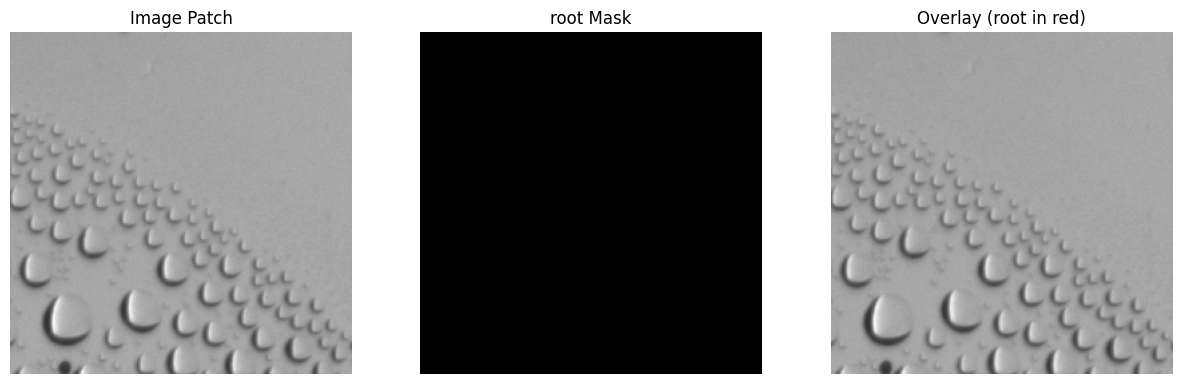

In [187]:
import random
import os
import cv2
import tifffile
import matplotlib.pyplot as plt

# Directories for images and shoot masks
TRAIN_IMG_DIR = "/Users/celinewu/Documents/dataset_patches1/images/train"
TRAIN_MASK_DIR = "/Users/celinewu/Documents/dataset_patches1/masks/train"

# List all image patches
image_patches = os.listdir(TRAIN_IMG_DIR)
if not image_patches:
    print("No train patches found.")
else:
    # Select a random image patch
    rand_patch_name = random.choice(image_patches)  # e.g. "233582_im5_patch72.png"
    print("Random image patch:", rand_patch_name)
    
    # Load the image
    img_path = os.path.join(TRAIN_IMG_DIR, rand_patch_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Construct shoot mask filename based on the naming convention
    base_no_ext = os.path.splitext(rand_patch_name)[0]  # e.g. "233582_im5_patch72"
    base_parts = base_no_ext.rsplit("_", 1)  # Split into ["233582_im5", "patch72"]
    mask_base = base_parts[0]  # "233582_im5"
    patch_index = base_parts[1]  # "patch72"
    
    # Construct the shoot mask filename
    shoot_mask_name = f"{mask_base}_shoot_{patch_index}.tif"
    shoot_mask_path = os.path.join(TRAIN_MASK_DIR, shoot_mask_name)
    
    # Debugging path
    print("Looking for root mask at:", shoot_mask_path)
    
    # Check if shoot mask exists and display
    if os.path.exists(shoot_mask_path):
        # Load the shoot mask
        shoot_mask = tifffile.imread(shoot_mask_path)
        print("root Mask Unique Values:", np.unique(shoot_mask))  # Debug: check mask content

        # Create the overlay
        overlay = img_rgb.copy()
        overlay[shoot_mask > 0] = [255, 0, 0]  # Highlight shoot mask in red
        blended = cv2.addWeighted(img_rgb, 0.6, overlay, 0.4, 0)
        
        # Display the image, shoot mask, and overlay
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(img_rgb)
        axs[0].set_title("Image Patch")
        axs[1].imshow(shoot_mask, cmap='gray')
        axs[1].set_title("root Mask")
        axs[2].imshow(blended)
        axs[2].set_title("Overlay (root in red)")
        for ax in axs:
            ax.axis('off')
        plt.show()
    else:
        print(f"No root mask found for this patch: {rand_patch_name}")
        # Print available mask files for debugging
        print("Available mask files:")
        print("\n".join(os.listdir(TRAIN_MASK_DIR)))


Random image patch: 235038_im4_patch57.png
Looking for root mask at: /Users/celinewu/Documents/dataset_patches1/masks/train/235038_im4_shoot_patch57.tif


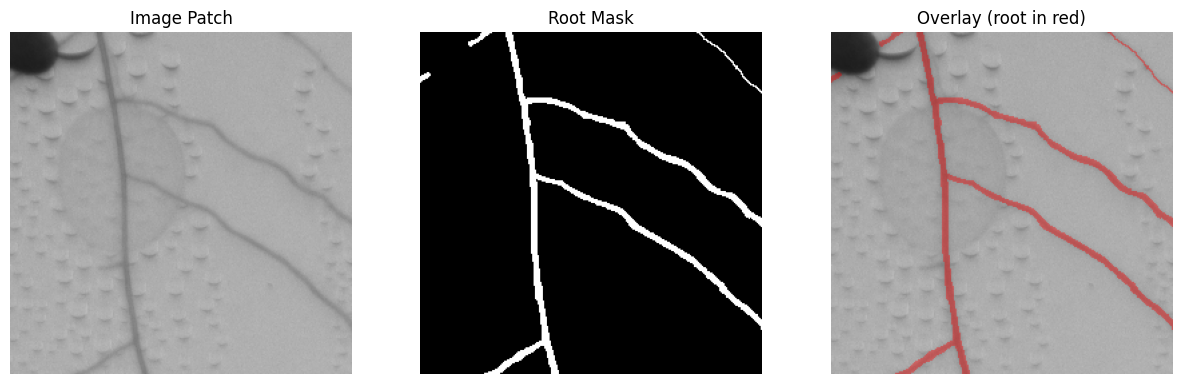

In [201]:
import random
import os
import cv2
import tifffile
import matplotlib.pyplot as plt

TRAIN_IMG_DIR = "/Users/celinewu/Documents/dataset_patches1/images/train"
TRAIN_MASK_DIR = "/Users/celinewu/Documents/dataset_patches1/masks/train"

# List all image patches
image_patches = os.listdir(TRAIN_IMG_DIR)
if not image_patches:
    print("No train patches found.")
else:
    rand_patch_name = random.choice(image_patches)  # e.g. 233582_im5_patch72.png
    print("Random image patch:", rand_patch_name)
    
    # Load image
    img_path = os.path.join(TRAIN_IMG_DIR, rand_patch_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Construct mask filenames based on the correct naming convention
    base_no_ext = os.path.splitext(rand_patch_name)[0]  # e.g. 233582_im5_patch72
    base_parts = base_no_ext.rsplit("_", 1)  # Split into ["233582_im5", "patch72"]
    
    # Correctly construct mask filenames
    
    root_mask_name = f"{base_parts[0]}_shoot_{base_parts[1]}.tif"
   
    
    root_mask_path  = os.path.join(TRAIN_MASK_DIR, root_mask_name)
   
   
    
    # Debugging paths
    print("Looking for root mask at:", root_mask_path)
  
  
    
    # Check if root mask exists and display
    if os.path.exists(root_mask_path):
        root_mask = tifffile.imread(root_mask_path)
        overlay = img_rgb.copy()
        overlay[root_mask > 0] = [255, 0, 0]  # Highlight root mask in red
        blended = cv2.addWeighted(img_rgb, 0.6, overlay, 0.4, 0)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(img_rgb)
        axs[0].set_title("Image Patch")
        axs[1].imshow(root_mask, cmap='gray')
        axs[1].set_title("Root Mask")
        axs[2].imshow(blended)
        axs[2].set_title("Overlay (root in red)")
        for ax in axs:
            ax.axis('off')
        plt.show()
    else:
        print(f"No root mask found for this patch: {rand_patch_name}")
        # Print available mask files for debugging
        

In [202]:
import os

# Directories for images and masks
TRAIN_IMG_DIR = "/Users/celinewu/Documents/dataset_patches1/images/train"
TRAIN_MASK_DIR = "/Users/celinewu/Documents/dataset_patches1/masks/train"

# List all image patches
image_patches = os.listdir(TRAIN_IMG_DIR)
missing_masks = []  # To collect details of missing masks

# Iterate through image patches and check for corresponding masks
for img_patch in image_patches:
    base_no_ext = os.path.splitext(img_patch)[0]  # e.g., "233582_im5_patch72"
    base_parts = base_no_ext.rsplit("_", 1)       # Split into ["233582_im5", "patch72"]
    
    # Construct expected mask filenames
 
    root_mask_name = f"{base_parts[0]}_shoot_{base_parts[1]}.tif"
    
    
    # Check existence of each mask
    root_mask_path  = os.path.join(TRAIN_MASK_DIR, root_mask_name)

    missing_for_patch = []
    if not os.path.exists(root_mask_path):
        missing_for_patch.append("shoot")
  
    
    # Record missing masks for this patch
    if missing_for_patch:
        missing_masks.append({
            "image_patch": img_patch,
            "missing_masks": missing_for_patch
        })

# Output the results
if not missing_masks:
    print("All image patches have corresponding masks.")
else:
    print(f"Found {len(missing_masks)} image patches with missing masks:")
    for entry in missing_masks:
        print(f" - {entry['image_patch']} is missing: {', '.join(entry['missing_masks'])}")


Found 16524 image patches with missing masks:
 - 231265_im1_patch74.png is missing: shoot
 - 235738_im5_patch156.png is missing: shoot
 - 232202_im4_patch132.png is missing: shoot
 - 236495_im1_patch55.png is missing: shoot
 - 234803_im5_patch107.png is missing: shoot
 - 231541_im4_patch157.png is missing: shoot
 - 232202_im5_patch67.png is missing: shoot
 - 220471_im5_patch82.png is missing: shoot
 - 231541_im5_patch42.png is missing: shoot
 - 233582_im3_patch179.png is missing: shoot
 - 234669_im1_patch130.png is missing: shoot
 - 230499_im3_patch158.png is missing: shoot
 - 235738_im1_patch189.png is missing: shoot
 - 232333_im2_patch114.png is missing: shoot
 - 236495_im5_patch181.png is missing: shoot
 - 235065_im4_patch42.png is missing: shoot
 - 233582_im1_patch94.png is missing: shoot
 - 230306_im5_patch114.png is missing: shoot
 - 230499_im5_patch23.png is missing: shoot
 - 220471_im1_patch185.png is missing: shoot
 - 235065_im4_patch56.png is missing: shoot
 - 233582_im1_patc

In [ ]:
import os
train_img_dir = "/Users/celinewu/Documents/dataset_patches1/images/train"
train_mask_dir = "/Users/celinewu/Documents/dataset_patches1/masks/train"
img_count = len(os.listdir(train_img_dir))
mask_count = len(os.listdir(train_mask_dir))
print(f"Image patches: {img_count}, Mask patches: {mask_count}")


In [ ]:
import os

# Directories for images and masks
TRAIN_IMG_DIR = "/Users/celinewu/Documents/dataset_patches1/images/train"
TRAIN_MASK_DIR = "/Users/celinewu/Documents/dataset_patches1/masks/train"

# List all image patches
image_patches = os.listdir(TRAIN_IMG_DIR)
deleted_patches = []  # To keep track of deleted patches

# Iterate through image patches and check for corresponding masks
for img_patch in image_patches:
    base_no_ext = os.path.splitext(img_patch)[0]  # e.g., "233582_im5_patch72"
    base_parts = base_no_ext.rsplit("_", 1)       # Split into ["233582_im5", "patch72"]
    
    # Construct expected mask filenames
    root_mask_name  = f"{base_parts[0]}_root_{base_parts[1]}.tif"
    shoot_mask_name = f"{base_parts[0]}_shoot_{base_parts[1]}.tif"
    seed_mask_name  = f"{base_parts[0]}_seed_{base_parts[1]}.tif"
    
    root_mask_path  = os.path.join(TRAIN_MASK_DIR, root_mask_name)
    shoot_mask_path = os.path.join(TRAIN_MASK_DIR, shoot_mask_name)
    seed_mask_path  = os.path.join(TRAIN_MASK_DIR, seed_mask_name)
    
    # Check for missing masks
    missing = not os.path.exists(root_mask_path) or not os.path.exists(shoot_mask_path) or not os.path.exists(seed_mask_path)
    
    if missing:
        # Delete the image patch
        img_path = os.path.join(TRAIN_IMG_DIR, img_patch)
        os.remove(img_path)
        
        # Delete the associated masks if they exist
        if os.path.exists(root_mask_path):
            os.remove(root_mask_path)
        if os.path.exists(shoot_mask_path):
            os.remove(shoot_mask_path)
        if os.path.exists(seed_mask_path):
            os.remove(seed_mask_path)
        
        # Track the deleted patch
        deleted_patches.append(img_patch)

# Output the results
if not deleted_patches:
    print("No patches with missing masks were found.")
else:
    print(f"Deleted {len(deleted_patches)} patches with missing masks:")
    for patch in deleted_patches:
        print(f" - {patch}")


In [ ]:
import random
import os
import cv2
import tifffile
import matplotlib.pyplot as plt

TRAIN_IMG_DIR = "/Users/celinewu/Documents/dataset_patches1/images/train"
TRAIN_MASK_DIR = "/Users/celinewu/Documents/dataset_patches1/masks/train"

# List all image patches
image_patches = os.listdir(TRAIN_IMG_DIR)
if not image_patches:
    print("No train patches found.")
else:
    rand_patch_name = random.choice(image_patches)  # e.g. 233582_im5_patch72.png
    print("Random image patch:", rand_patch_name)
    
    # Load image
    img_path = os.path.join(TRAIN_IMG_DIR, rand_patch_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Construct mask filenames based on the correct naming convention
    base_no_ext = os.path.splitext(rand_patch_name)[0]  # e.g. 233582_im5_patch72
    base_parts = base_no_ext.rsplit("_", 1)  # Split into ["233582_im5", "patch72"]
    
    # Correctly construct mask filenames
    root_mask_name  = f"{base_parts[0]}_root_{base_parts[1]}.tif"
    shoot_mask_name = f"{base_parts[0]}_shoot_{base_parts[1]}.tif"
    seed_mask_name  = f"{base_parts[0]}_seed_{base_parts[1]}.tif"
    
    root_mask_path  = os.path.join(TRAIN_MASK_DIR, root_mask_name)
    shoot_mask_path = os.path.join(TRAIN_MASK_DIR, shoot_mask_name)
    seed_mask_path  = os.path.join(TRAIN_MASK_DIR, seed_mask_name)
    
    # Debugging paths
    print("Looking for root mask at:", root_mask_path)
    print("Looking for shoot mask at:", shoot_mask_path)
    print("Looking for seed mask at:", seed_mask_path)
    
    # Check if root mask exists and display
    if os.path.exists(root_mask_path):
        root_mask = tifffile.imread(root_mask_path)
        overlay = img_rgb.copy()
        overlay[root_mask > 0] = [255, 0, 0]  # Highlight root mask in red
        blended = cv2.addWeighted(img_rgb, 0.6, overlay, 0.4, 0)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(img_rgb)
        axs[0].set_title("Image Patch")
        axs[1].imshow(root_mask, cmap='gray')
        axs[1].set_title("Root Mask")
        axs[2].imshow(blended)
        axs[2].set_title("Overlay (root in red)")
        for ax in axs:
            ax.axis('off')
        plt.show()
    else:
        print(f"No root mask found for this patch: {rand_patch_name}")
        # Print available mask files for debugging
        

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Directory for train image patches
TRAIN_IMG_DIR = "/Users/celinewu/Documents/dataset_patches1/images/train"

# Threshold for nearly black pixels
BLACK_THRESHOLD = 10  # Pixels with intensity < 10 are considered nearly black

# List all image patches
image_patches = os.listdir(TRAIN_IMG_DIR)
black_patches = []

# Check for nearly black patches
for img_patch in image_patches:
    img_path = os.path.join(TRAIN_IMG_DIR, img_patch)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    if img is None:
        print(f"Failed to read: {img_patch}")
        continue
    
    # Check if the patch is nearly black
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if np.max(gray_img) < BLACK_THRESHOLD:
        black_patches.append(img_patch)

# Display results
if not black_patches:
    print("No nearly black patches found.")
else:
    print(f"Found {len(black_patches)} nearly black patches.")
    
    # Create a grid to display all nearly black patches
    cols = 5  # Number of columns for the grid
    rows = (len(black_patches) + cols - 1) // cols  # Calculate number of rows
    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 3))

    # Flatten axes for consistent handling
    axs = axs.flatten()

    # Display all nearly black patches
    for i, patch in enumerate(black_patches):
        img_path = os.path.join(TRAIN_IMG_DIR, patch)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_rgb)
        axs[i].set_title(patch, fontsize=8)
        axs[i].axis('off')

    # Hide unused axes
    for j in range(len(black_patches), len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:
import os
import cv2
import numpy as np

# Directory for train image patches
TRAIN_IMG_DIR = "/Users/celinewu/Documents/dataset_patches1/images/train"
TRAIN_MASK_DIR = "/Users/celinewu/Documents/dataset_patches1/masks/train"

# Threshold for nearly black pixels
BLACK_THRESHOLD = 10  # Pixels with intensity < 10 are considered nearly black

# List all image patches
image_patches = os.listdir(TRAIN_IMG_DIR)
black_patches = []

# Check for nearly black patches
for img_patch in image_patches:
    img_path = os.path.join(TRAIN_IMG_DIR, img_patch)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    if img is None:
        print(f"Failed to read: {img_patch}")
        continue
    
    # Check if the patch is nearly black
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if np.max(gray_img) < BLACK_THRESHOLD:
        black_patches.append(img_patch)

# Delete the nearly black patches and their corresponding masks
if not black_patches:
    print("No nearly black patches found.")
else:
    print(f"Found {len(black_patches)} nearly black patches.")
    
    for patch in black_patches:
        # Delete the image patch
        img_path = os.path.join(TRAIN_IMG_DIR, patch)
        os.remove(img_path)
        print(f"Deleted image patch: {patch}")
        
        # Construct corresponding mask filenames based on naming convention
        base_no_ext = os.path.splitext(patch)[0]  # e.g., "233582_im5_patch72"
        base_parts = base_no_ext.rsplit("_", 1)   # Split into ["233582_im5", "patch72"]
        
        root_mask_name  = f"{base_parts[0]}_root_{base_parts[1]}.tif"
        shoot_mask_name = f"{base_parts[0]}_shoot_{base_parts[1]}.tif"
        seed_mask_name  = f"{base_parts[0]}_seed_{base_parts[1]}.tif"
        
        root_mask_path  = os.path.join(TRAIN_MASK_DIR, root_mask_name)
        shoot_mask_path = os.path.join(TRAIN_MASK_DIR, shoot_mask_name)
        seed_mask_path  = os.path.join(TRAIN_MASK_DIR, seed_mask_name)
        
        # Delete corresponding masks if they exist
        if os.path.exists(root_mask_path):
            os.remove(root_mask_path)
            print(f"Deleted root mask: {root_mask_name}")
        if os.path.exists(shoot_mask_path):
            os.remove(shoot_mask_path)
            print(f"Deleted shoot mask: {shoot_mask_name}")
        if os.path.exists(seed_mask_path):
            os.remove(seed_mask_path)
            print(f"Deleted seed mask: {seed_mask_name}")

    print("Deletion complete!")


In [200]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Directory for train image patches
TRAIN_IMG_DIR = "/Users/celinewu/Documents/dataset_patches1/images/train"

# Threshold for nearly black pixels
BLACK_THRESHOLD = 10  # Pixels with intensity < 10 are considered nearly black

# List all image patches
image_patches = os.listdir(TRAIN_IMG_DIR)
black_patches = []

# Check for nearly black patches
for img_patch in image_patches:
    img_path = os.path.join(TRAIN_IMG_DIR, img_patch)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    if img is None:
        print(f"Failed to read: {img_patch}")
        continue
    
    # Check if the patch is nearly black
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if np.max(gray_img) < BLACK_THRESHOLD:
        black_patches.append(img_patch)

# Display results
if not black_patches:
    print("No nearly black patches found.")
else:
    print(f"Found {len(black_patches)} nearly black patches.")
    
    # Create a grid to display all nearly black patches
    cols = 5  # Number of columns for the grid
    rows = (len(black_patches) + cols - 1) // cols  # Calculate number of rows
    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 3))

    # Flatten axes for consistent handling
    axs = axs.flatten()

    # Display all nearly black patches
    for i, patch in enumerate(black_patches):
        img_path = os.path.join(TRAIN_IMG_DIR, patch)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_rgb)
        axs[i].set_title(patch, fontsize=8)
        axs[i].axis('off')

    # Hide unused axes
    for j in range(len(black_patches), len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()


No nearly black patches found.
